In [1]:
%matplotlib notebook
import numpy as np
import ctypes    

from numba.experimental import jitclass
from numba import int32, float32    # import the types

g = 9.81
MH2 = 3e-27
MCG = 66e-27




class Particle:
    """Define physics of elastic collision."""
    
    def __init__(self, mass, radius, position, velocity):
        """Initialize a Particle object
        
        mass the mass of particle
        radius the radius of particle
        position the position vector of particle
        velocity the velocity vector of particle
        """
        self.mass = mass
        self.radius = radius
        
        # last position and velocity
        self.position = np.array(position)
        self.velocity = np.array(velocity)
        
        # all position and velocities recorded during the simulation
        self.solpos = [np.copy(self.position)]
        self.solvel = [np.copy(self.velocity)]
        self.solvel_mag = [np.linalg.norm(np.copy(self.velocity))]
        
    def compute_step(self, step):
        """Compute position of next step."""
        self.velocity = np.copy(self.velocity) 
        self.position += step * self.velocity
        self.solpos.append(np.copy(self.position)) 
        self.solvel.append(np.copy(self.velocity)) 
        self.solvel_mag.append(np.linalg.norm(np.copy(self.velocity))) 
        

    
    
    def check_coll(self, particle):
        """Check if there is a collision with another particle."""
        
        r1, r2 = self.radius, particle.radius
        x1, x2 = self.position, particle.position
        di = x2-x1
        norm = np.linalg.norm(di)
        if norm-(r1+r2)*1.1 < 0:
            return True
        else:
            return False

    
    def compute_coll(self, particle, step):
        """Compute velocity after collision with another particle."""
        m1, m2 = self.mass, particle.mass
        r1, r2 = self.radius, particle.radius
        v1, v2 = self.velocity, particle.velocity
        x1, x2 = self.position, particle.position
        di = x2-x1
        norm = np.linalg.norm(di)
        if norm-(r1+r2)*1.1 < step*abs(np.dot(v1-v2, di))/norm:
            self.velocity = v1 - 2. * m2/(m1+m2) * np.dot(v1-v2, di) / (np.linalg.norm(di)**2.) * di
            particle.velocity = v2 - 2. * m1/(m2+m1) * np.dot(v2-v1, (-di)) / (np.linalg.norm(di)**2.) * (-di)
            

    def compute_refl(self, step, size):
        """Compute velocity after hitting an edge.
        step the computation step
        size the medium size
        """
        r, v, x = self.radius, self.velocity, self.position
        projx = step*abs(np.dot(v,np.array([1.,0.])))
        projy = step*abs(np.dot(v,np.array([0.,1.])))
        if abs(x[0])-r < projx:
            self.velocity[0] = np.abs(self.velocity[0])
        elif abs(size-x[0])-r < projx:
            self.velocity[0] = np.abs(self.velocity[0])*-1
        if abs(x[1])-r < projy or abs(size-x[1])-r < projy:
            self.velocity[1] *= -1.
           
def solve_step(particle_list, step, size):
    """Solve a step for every particle."""
    
    # Detect edge-hitting and collision of every particle
    for i in range(len(particle_list)):
        particle_list[i].velocity = particle_list[i].velocity - np.append(timestep*g, 0)
        particle_list[i].compute_refl(step,size)
        for j in range(i+1,len(particle_list)):
                particle_list[i].compute_coll(particle_list[j],step)    

                
    # Compute position of every particle  
    for particle in particle_list:
        particle.compute_step(step)


<IPython.core.display.Javascript object>


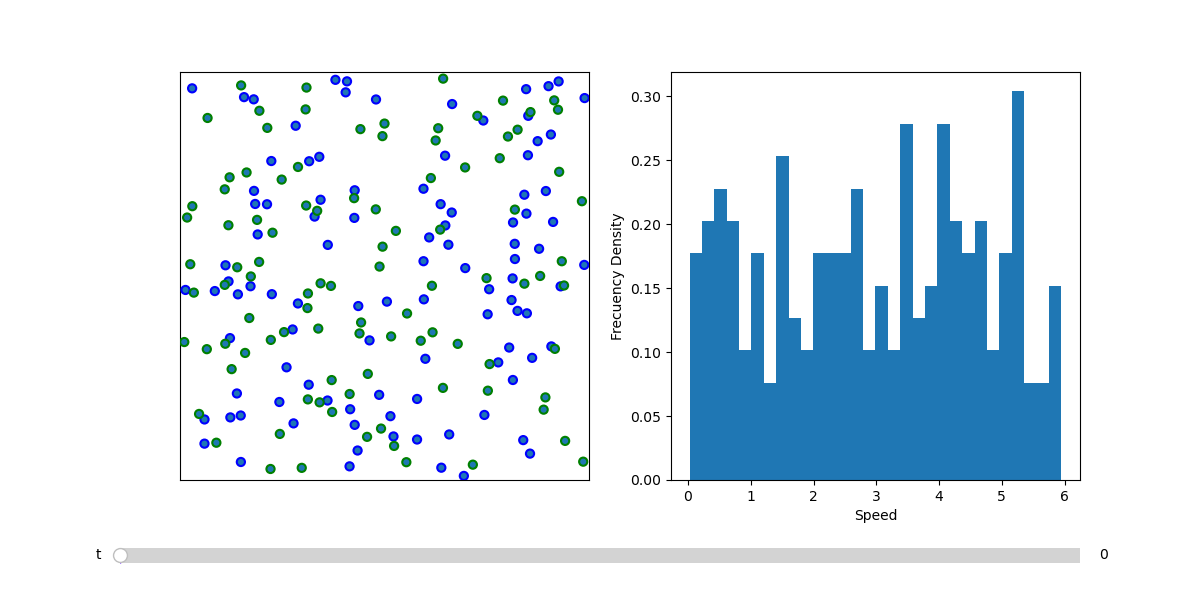

In [2]:
def init_list_random(N, radius, mass, boxsize):
    """Generate N Particle objects in a random way in a list."""
    particle_list = []

    for i in range(N):
        
        v_mag = np.random.rand(1)*6#00
        v_ang = np.random.rand(1)*2*np.pi
        v = np.append(v_mag*np.cos(v_ang), v_mag*np.sin(v_ang))
        
        collision = True
        while(collision == True):
            
            collision = False
            pos = radius + np.random.rand(2)*(boxsize-2*radius) 
            newparticle = Particle(mass, radius, pos, v)
            for j in range(len(particle_list)):

                collision = newparticle.check_coll( particle_list[j] )

                if collision == True:
                    break

        particle_list.append(newparticle)
    return particle_list



particle_number = 100
boxsize = 100.

# You need a larger tfin and stepnumber to get the equilibrium state. But the computation takes more time.
tfin = 10
stepnumber = 400

timestep = tfin/stepnumber

particle_list = init_list_random(particle_number, radius = 1, mass = MH2, boxsize = 100)
particle_list = particle_list + init_list_random(particle_number, radius = 1, mass = MCG, boxsize = 100)

particle_number *=2
# Compute simulation (It takes some time if stepnumber and particle_number are large)
for i in range(stepnumber):
    solve_step(particle_list, timestep, boxsize)
    #print(i)






################################################################################################################################


# Visualization of the solution with matplotlib. It use a slider to change the time


import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,2,1)

hist = fig.add_subplot(1,2,2)

plt.subplots_adjust(bottom=0.2,left=0.15)

ax.axis('equal')
ax.axis([-1, 30, -1, 30])

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim([0,boxsize])
ax.set_ylim([0,boxsize])


H2Particles = []
CGParticles = []
for particle in particle_list:
    pm = particle.mass
    
    if pm == MH2:
        H2Particles.append(particle)
    elif pm == MCG:
        CGParticles.append(particle)


# Draw Particles as circles
circle = [None]*particle_number

for i in range(particle_number):
    if i <= 100:
        circle[i] = plt.Circle((particle_list[i].solpos[0][0], particle_list[i].solpos[0][1]), particle_list[i].radius, ec="Blue", lw=1.5, zorder=20)
        ax.add_patch(circle[i])
    elif i > 100:
        circle[i] = plt.Circle((particle_list[i].solpos[0][0], particle_list[i].solpos[0][1]), particle_list[i].radius, ec="g", lw=1.5, zorder=20)
        ax.add_patch(circle[i])

# # Graph Particles speed histogram
vel_mod = [particle_list[i].solvel_mag[0] for i in range(len(particle_list))]
hist.hist(vel_mod, bins= 30, density = True, label = "Simulation Data")
hist.set_xlabel("Speed")
 
hist.set_ylabel("Frecuency Density")



# Compute 2d Boltzmann distribution

#total energy should be constant for any time index
def total_Energy(particle_list, index): 
    return sum([particle_list[i].mass / 2. * particle_list[i].solvel_mag[index]**2  for i in range(len(particle_list))]) + sum([particle_list[i].solpos[i][0] * 9.81 * particle_list[i].mass  for i in range(len(particle_list))])


# E = total_Energy(particle_list, 0)
# Average_E = E/len(particle_list) 
# k = 1.38064852e-23
# T = 2*Average_E/(2*k)
# m = particle_list[0].mass
# v = np.linspace(0,10,120)
# fv = m*np.exp(-m*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
# hist.plot(v,fv, label = "Maxwell–Boltzmann distribution") 
# hist.legend(loc ="upper right")


from matplotlib.widgets import Slider

slider_ax = plt.axes([0.1, 0.05, 0.8, 0.05])
slider = Slider(slider_ax,      # the axes object containing the slider
                  't',            # the name of the slider parameter
                  0,          # minimal value of the parameter
                  tfin,          # maximal value of the parameter
                  valinit=0,  # initial value of the parameter 
                  color = '#5c05ff' 
                 )


def boltzman_dis(h,g,c,M,E):
        Average_E = E/100 
        k = 1.38064852e-23
        T = 2*Average_E/(2*k)
        KT = k*T
        return c*np.exp(-1*(g*h*M)/KT)


def update(time):
    i = int(np.rint(time/timestep))
    
    #ax.set_title('Energy =' + str(Energy[i]))
    
    # Draw Particles as circles
    for j in range(particle_number):
        circle[j].center = particle_list[j].solpos[i][0], particle_list[j].solpos[i][1]
    hist.clear()    
    
    # Graph Particles speed histogram
    pos_mod = [particle_list[j].solpos[i][0] for j in range(len(particle_list))]
    x, y, _ = hist.hist(pos_mod[:100], bins= 30, density = True, label = "Simulation Data", range = (0,100), alpha = 0.5)
    hist.set_xlabel("X Position")
    hist.set_ylabel("Frequency Density")
    #hist.xlim(0,200)
    
    
    
    boltz_list = np.zeros(100)
    E = total_Energy(particle_list[:100], 0)
    Average_E = E/100
    k = 1.38064852e-23
    T = 2*Average_E/(2*k)
    print(T*k)
    c = x.max()
    for f in range(0,100):
        boltz_list[f] = boltzman_dis(f,g,c,MH2,E)
    hist.plot(range(0,100),boltz_list, label = "Boltzmann distribution") 

    hist.legend(loc ="upper right")
    
    
    
    
    
     # Graph Particles speed histogram
    pos_mod = [particle_list[j].solpos[i][0] for j in range(len(particle_list))]
    x, y, _ = hist.hist(pos_mod[101:], bins= 30, density = True, label = "Simulation Data",range = (0,100), alpha = 0.5)
    hist.set_xlabel("X Position")
    hist.set_ylabel("Frequency Density")
    #hist.xlim(0,200)
    
    
    
    boltz_list = np.zeros(100)
    E = total_Energy(particle_list[101:], 0)
    Average_E = E/100 
    k = 1.38064852e-23
    T = 2*Average_E/(2*k)
    print(T*k)
    c = x.max()
    for f in range(0,100):
        boltz_list[f] = boltzman_dis(f,g,c,MCG,E)
    hist.plot(range(0,100),boltz_list, label = "Boltzmann distribution") 
   

    hist.legend(loc ="upper right")
   
   
slider.on_changed(update)
plt.show()


In [3]:
yposit = np.zeros([particle_number,2])
for j in range(particle_number):
        print(particle_list[j].solpos[i][0], particle_list[j].solpos[i][1])
        

13.802445742340144 1.94109652756249
-148.79417256785936 71.2787376632558
-18.499241896598672 35.79913800250984
-19.684350887134098 96.17497513041195
34.14816493403311 82.68546948650442
4.157842892928477 14.818297134524489
50.63261175575385 39.016256439601115
55.14815247003783 181.34907414709764
96.82100703167293 76.96901458004562
6.581386408415822 69.37115745289275
76.29772722680067 73.10237733057983
47.457048454115075 27.446210156113935
83.18990428002274 95.69347867025787
84.09423807718223 81.03074446647415
-15.37647745776009 12.431213380791291
92.5975969072662 5.492087965311548
49.88331416288467 230.97912696362562
-13.414648950136993 84.7693848047279
28.907653414050337 16.04231721656917
94.0590185703743 44.33190486248051
31.15571906152549 51.889170553830155
-24.92592676793723 90.27984762466254
34.820194012761334 73.88543443557468
20.243474760913927 33.47659656336991
12.651076731623954 9.886452680596115
-263.83836225320044 55.56382740516209
5.6477761247202185 10.622769347901844
-9.404

In [4]:
np.mean(yposit[:,0])

0.0

In [5]:
print(len(circle))

200


In [6]:
print(boxsize)

100.0


In [7]:

range((len(particle_list))

SyntaxError: incomplete input (3826538970.py, line 1)

In [ ]:
    boltz_list = np.zeros(200)
    E = total_Energy(particle_list, 0)
    Average_E = E/len(particle_list) 
    k = 1.38064852e-23
    T = 2*Average_E/(2*k)
    print(T*k)
    c = x.max()
    for f in range(0,200):
        boltz_list[f] = boltzman_dis(f,g,c)
    hist.plot(range(0,200),boltz_list, label = "Maxwell–Boltzmann distribution") 


In [ ]:
particle_list[199].solpos[151]

In [ ]:
E = total_Energy(particle_list[101:], 0)
Average_E = E/100 
k = 1.38064852e-23
T = 2*Average_E/(2*k)

In [ ]:
T
